# Description

This notebook performs cross-vendor QA checks to compare vendors in terms of:
   - Difference and intersection of vendor universes
   - Time intervals, i.e. which vendor has the longest data available for each full symbol in intersecting universe
   - Data quality (bad data [%], missing bars [%], volume=0 [%], NaNs [%]) for intersecting universe and time intervals

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import im_v2.crypto_chassis.data.client as iccdc
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-7b09bce4-3e52-4a0e-a1ae-726f28811027.json'
INFO  # Git
    branch_name='CmTask1999_move_plot_bad_data_by_year_month'
    hash='762540791'
    # Last commits:
      * 762540791 Nina Lee Cm task1999 update compare data calls in the notebooks (#2040)    (73 minutes ago) Wed Jun 1 15:10:50 2022  (HEAD -> CmTask1999_move_plot_bad_data_by_year_month, origin/master, origin/HEAD, master)
      * d4aab52c5 cryptomtc AmpTask1786_Integrate_20220531 (#2045)                            (   2 hours ago) Wed Jun 1 14:27:35 2022           
      * bf8761a75 Daniil Tikhomirov CMTask2043: Update parquet files merging (#2049)                  (   3 hours ago) Wed Jun 1 13:48:36 2022           
# Machine info
    system=Linux
    node name=338f016b0bee
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count

# Configs

In [3]:
def get_master_cross_vendor_qa_config() -> cconconf.Config:
    """
    Get task1966-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            "ccxt": {
                "universe_version": "v3",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "spot",
                "aws_profile": "ck",
            },
            "crypto_chassis": {
                "universe_version": "v1",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "spot",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_master_cross_vendor_qa_config()
print(config)

data:
  ccxt:
    universe_version: v3
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    aws_profile: ck
  crypto_chassis:
    universe_version: v1
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Compare universes

In [5]:
crypto_chassis_client = iccdc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["crypto_chassis"]
)
ccxt_client = icdcl.CcxtHistoricalPqByTileClient(**config["data"]["ccxt"])

In [6]:
crypto_chassis_universe = crypto_chassis_client.get_universe()
ccxt_universe = ccxt_client.get_universe()

In [7]:
common_universe = list(set(crypto_chassis_universe) & set(ccxt_universe))

In [8]:
compare_universe = hprint.set_diff_to_str(
    crypto_chassis_universe, ccxt_universe, add_space=True
)
print(compare_universe)

* obj1: (29) binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::EOS_USDT binance::ETH_USDT binance::SOL_USDT ftx::BNB_USDT ftx::BTC_USDT ftx::DOGE_USDT ftx::ETH_USDT ftx::SOL_USDT ftx::XRP_USDT gateio::ADA_USDT gateio::BNB_USDT gateio::BTC_USDT gateio::DOGE_USDT gateio::EOS_USDT gateio::ETH_USDT gateio::SOL_USDT gateio::XRP_USDT kucoin::ADA_USDT kucoin::BNB_USDT kucoin::BTC_USDT kucoin::DOGE_USDT kucoin::EOS_USDT kucoin::ETH_USDT kucoin::SOL_USDT kucoin::XRP_USDT

* obj2: (38) binance::ADA_USDT binance::AVAX_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::EOS_USDT binance::ETH_USDT binance::LINK_USDT binance::SOL_USDT ftx::BNB_USDT ftx::BTC_USDT ftx::DOGE_USDT ftx::ETH_USDT ftx::LINK_USDT ftx::SOL_USDT ftx::XRP_USDT gateio::ADA_USDT gateio::AVAX_USDT gateio::BNB_USDT gateio::BTC_USDT gateio::DOGE_USDT gateio::EOS_USDT gateio::ETH_USDT gateio::FIL_USDT gateio::LINK_USDT gateio::SOL_USDT gateio::XRP_USDT kucoin::ADA_USDT kucoin::AVAX_US

# Compare Binance QA stats

In [9]:
binance_universe = [
    full_symbol
    for full_symbol in common_universe
    if full_symbol.startswith("binance")
]
binance_universe

['binance::DOGE_USDT',
 'binance::ADA_USDT',
 'binance::BTC_USDT',
 'binance::ETH_USDT',
 'binance::SOL_USDT',
 'binance::EOS_USDT',
 'binance::BNB_USDT']

In [10]:
ccxt_binance_data = ccxt_client.read_data(
    binance_universe, **config["data"]["read_data"]
)
ccxt_binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2018-08-17 00:00:00+00:00,binance::ADA_USDT,0.09479,41334.200000
2018-08-17 00:00:00+00:00,binance::BNB_USDT,9.77780,520.660000
2018-08-17 00:00:00+00:00,binance::BTC_USDT,6311.64000,9.967395


In [11]:
crypto_chassis_binance_data = crypto_chassis_client.read_data(
    binance_universe, **config["data"]["read_data"]
)
crypto_chassis_binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2018-01-01 00:00:00+00:00,binance::BTC_USDT,13707.92,2.844266
2018-01-01 00:00:00+00:00,binance::ETH_USDT,732.75,19.772470
2018-01-01 00:01:00+00:00,binance::BTC_USDT,13694.92,2.113138


In [12]:
crypto_chassis_vendor = "Crypto Chassis"
crypto_chassis_timestamp_binance_stats = ramccqa.get_timestamp_stats(
    crypto_chassis_binance_data, crypto_chassis_vendor
)
ccxt_vendor = "CCXT"
ccxt_timestamp_binance_stats = ramccqa.get_timestamp_stats(
    ccxt_binance_data, ccxt_vendor
)
#
binance_timestamp_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_timestamp_binance_stats,
    ccxt_timestamp_binance_stats,
)
binance_timestamp_stats_qa

min_timestamp                                       max_timestamp                           days_available      
                              Crypto Chassis                      CCXT            Crypto Chassis                      CCXT Crypto Chassis  CCXT
binance::ADA_USDT  2021-08-07 00:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 10:05:00+00:00 2022-05-06 13:43:00+00:00            284  1358
binance::BNB_USDT  2021-08-07 00:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 13:49:00+00:00            284  1358
binance::BTC_USDT  2018-01-01 00:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 13:53:00+00:00           1598  1358
binance::DOGE_USDT 2021-08-07 00:00:00+00:00 2019-07-05 12:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 13:56:00+00:00            284  1036
binance::EOS_USDT  2018-05-28 05:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 13:59:00+00:00           1451  1358
binance::ETH_USDT  2018-01-01 00:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 14:02:00+00:00           1598  1358
binance::SOL_USDT  2021-10-13 17:49:00+00:00 2020-08-11 06:00:00+00:00 2022-05-18 10:06:00+00:00 2022-05-06 14:08:00+00:00            216   633

In [13]:
agg_level_full_symbol = ["full_symbol"]
crypto_chassis_bad_data_binance_stats = ramccqa.get_bad_data_stats(
    crypto_chassis_binance_data, agg_level_full_symbol, crypto_chassis_vendor
)
ccxt_bad_data_binance_stats = ramccqa.get_bad_data_stats(
    ccxt_binance_data, agg_level_full_symbol, ccxt_vendor
)
#
binance_bad_data_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_binance_stats,
    ccxt_bad_data_binance_stats,
)
binance_bad_data_stats_qa

bad data [%]            missing bars [%]             volume=0 [%]                  NaNs [%]     
                   Crypto Chassis       CCXT   Crypto Chassis      CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
binance::ADA_USDT        0.138439   2.974477         0.138439  0.237177            0.0   2.737300            0.0  0.0
binance::BNB_USDT        0.136486   0.528638         0.136486  0.237176            0.0   0.291461            0.0  0.0
binance::BTC_USDT        0.397745   0.248166         0.397745  0.237125            0.0   0.011041            0.0  0.0
binance::DOGE_USDT       0.139904  24.081726         0.139904  0.200341            0.0  23.881385            0.0  0.0
binance::EOS_USDT        0.984617   0.917571         0.984617  0.237175            0.0   0.680396            0.0  0.0
binance::ETH_USDT        0.434022   0.251385         0.434022  0.237175            0.0   0.014210            0.0  0.0
binance::SOL_USDT        0.273382   2.572014         0.273382  0.147367            0.0   2.424647            0.0  0.0

In [14]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
crypto_chassis_bad_data_binance_stats_by_year_month = ramccqa.get_bad_data_stats(
    crypto_chassis_binance_data,
    agg_level_full_symbol_year_month,
    crypto_chassis_vendor,
)
ccxt_bad_data_binance_stats_by_year_month = ramccqa.get_bad_data_stats(
    ccxt_binance_data, agg_level_full_symbol_year_month, ccxt_vendor
)
#
binance_bad_data_stats_by_year_month_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_binance_stats_by_year_month,
    ccxt_bad_data_binance_stats_by_year_month,
)
binance_bad_data_stats_by_year_month_qa

bad data [%]            missing bars [%]             volume=0 [%]                  NaNs [%]     
                           Crypto Chassis       CCXT   Crypto Chassis      CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
binance::ADA_USDT  2021 8        0.750000   0.604839         0.750000  0.604839            0.0   0.000000            0.0  0.0
                        9        0.395833   0.277778         0.395833  0.277778            0.0   0.000000            0.0  0.0
                        10       0.208333   0.000000         0.208333  0.000000            0.0   0.000000            0.0  0.0
                        11       0.002315   0.000000         0.002315  0.000000            0.0   0.000000            0.0  0.0
                        12       0.071685   0.000000         0.071685  0.000000            0.0   0.000000            0.0  0.0
                   2022 1        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        2        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        3        0.000000   0.002240         0.000000  0.000000            0.0   0.002240            0.0  0.0
                        4        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        5        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
binance::BNB_USDT  2021 8        0.750000   0.604839         0.750000  0.604839            0.0   0.000000            0.0  0.0
                        9        0.393519   0.277778         0.393519  0.277778            0.0   0.000000            0.0  0.0
                        10       0.192652   0.000000         0.192652  0.000000            0.0   0.000000            0.0  0.0
                        11       0.002315   0.000000         0.002315  0.000000            0.0   0.000000            0.0  0.0
                        12       0.071685   0.000000         0.071685  0.000000            0.0   0.000000            0.0  0.0
                   2022 1        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        2        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        3        0.000000   0.002240         0.000000  0.000000            0.0   0.002240            0.0  0.0
                        4        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        5        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
binance::BTC_USDT  2018 8        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        9        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        10       0.470430   0.470430         0.470430  0.470430            0.0   0.000000            0.0  0.0
                        11       0.972222   0.972222         0.972222  0.972222            0.0   0.000000            0.0  0.0
                        12       0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                   2019 1        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        2        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        3        0.806452   0.806452         0.806452  0.806452            0.0   0.000000            0.0  0.0
                        4        0.000000   0.000000         0.000000  0.000000            0.0   0.000000            0.0  0.0
                        5        1.344086   1.344086         1.344086  1.344086            0.0   0.000000            0.0  0

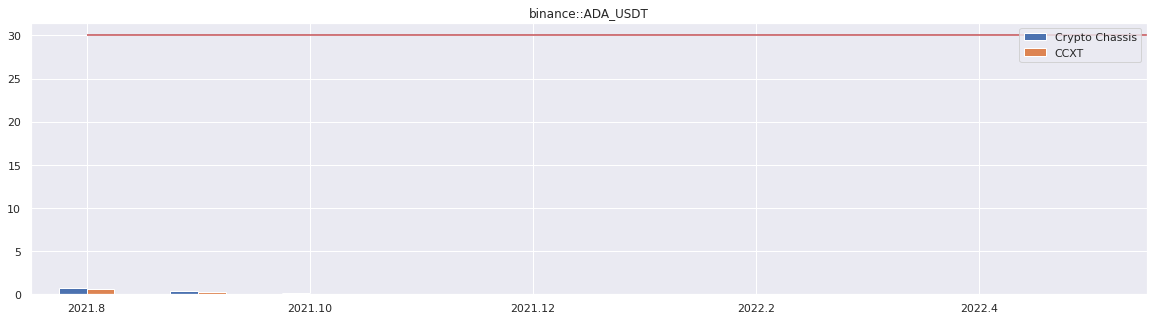

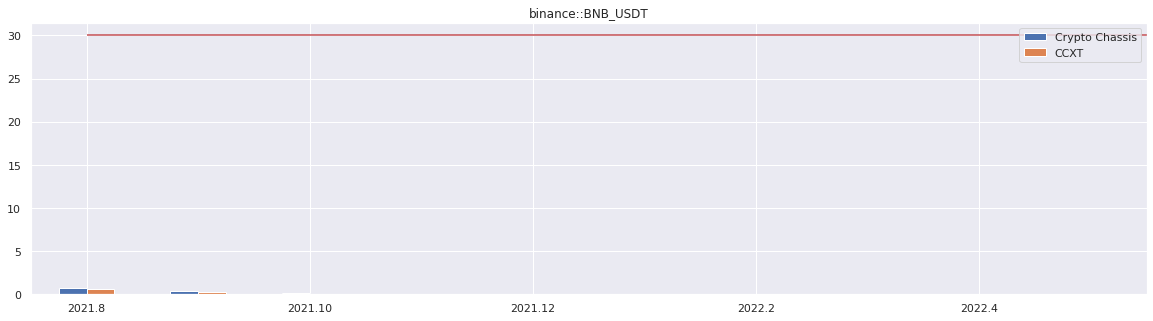

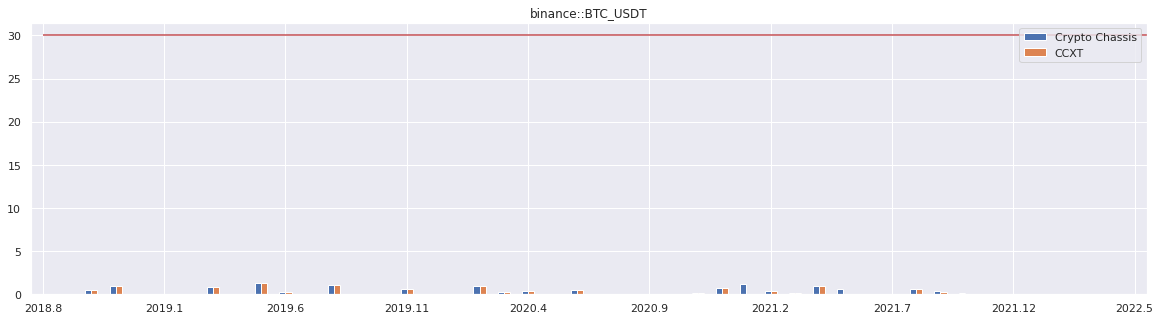

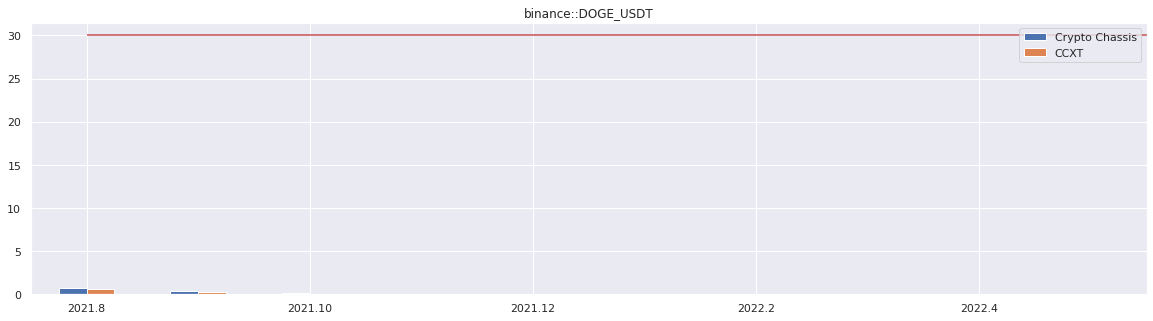

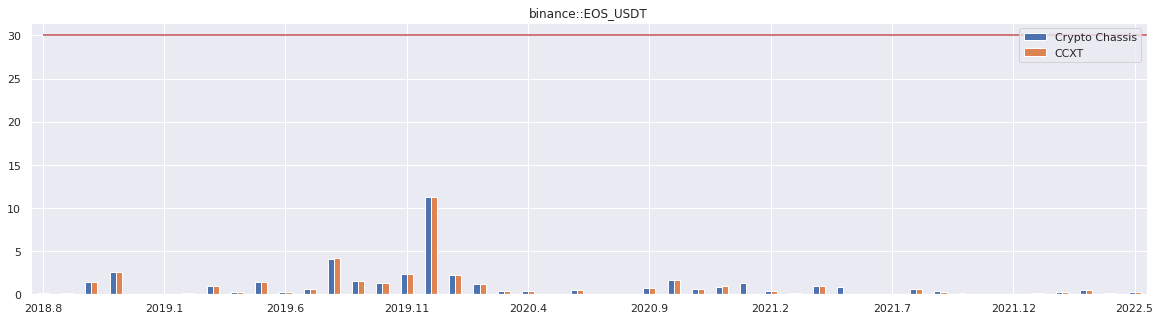

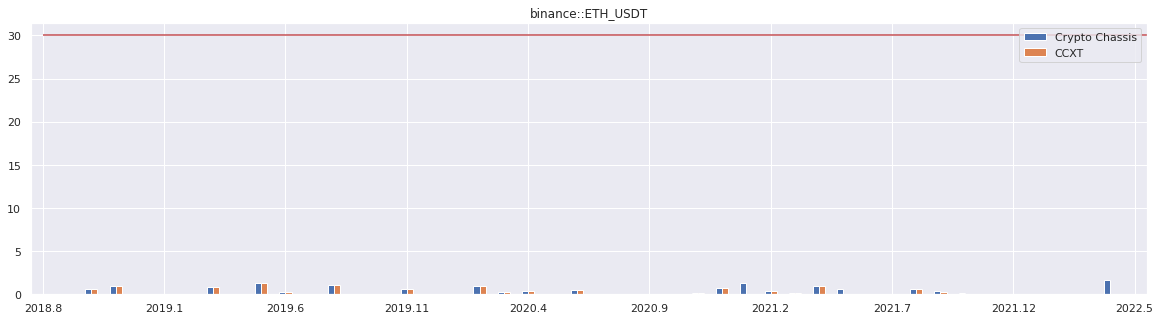

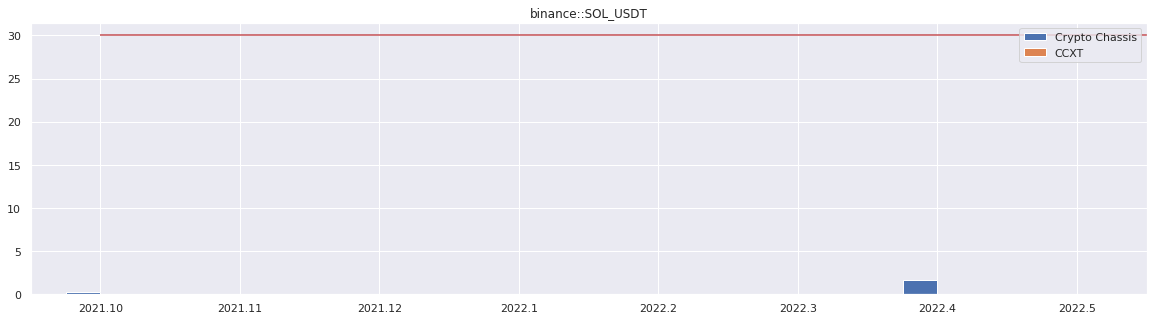

In [15]:
ramccqa.plot_bad_data_by_year_month_stats(
    binance_bad_data_stats_by_year_month_qa, config["stats"]["threshold"]
)

# Compare FTX QA stats

In [16]:
ftx_universe = [
    full_symbol
    for full_symbol in common_universe
    if full_symbol.startswith("ftx")
]
ftx_universe

['ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::XRP_USDT',
 'ftx::ETH_USDT']

In [17]:
ccxt_ftx_data = ccxt_client.read_data(ftx_universe, **config["data"]["read_data"])
ccxt_ftx_data.head(3)

,full_symbol,close,volume
timestamp,,,
2020-03-28 14:40:00+00:00,ftx::BTC_USDT,6240.000,0.0
2020-03-28 14:40:00+00:00,ftx::ETH_USDT,128.765,0.0
2020-03-28 14:41:00+00:00,ftx::BTC_USDT,6235.750,0.0


In [18]:
crypto_chassis_ftx_data = crypto_chassis_client.read_data(
    ftx_universe, **config["data"]["read_data"]
)
crypto_chassis_ftx_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-08-07 00:00:00+00:00,ftx::BNB_USDT,342.446000,52.8100
2021-08-07 00:00:00+00:00,ftx::BTC_USDT,42808.000000,11.9401
2021-08-07 00:00:00+00:00,ftx::DOGE_USDT,0.204726,151.0000


In [19]:
crypto_chassis_timestamp_ftx_stats = ramccqa.get_timestamp_stats(
    crypto_chassis_ftx_data, crypto_chassis_vendor
)
ccxt_timestamp_ftx_stats = ramccqa.get_timestamp_stats(ccxt_ftx_data, ccxt_vendor)
#
ftx_timestamp_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_timestamp_ftx_stats,
    ccxt_timestamp_ftx_stats,
)
ftx_timestamp_stats_qa

min_timestamp                                       max_timestamp                           days_available     
                          Crypto Chassis                      CCXT            Crypto Chassis                      CCXT Crypto Chassis CCXT
ftx::BNB_USDT  2021-08-07 00:00:00+00:00 2020-04-09 20:55:00+00:00 2022-05-18 10:03:00+00:00 2022-05-06 14:16:00+00:00            284  756
ftx::BTC_USDT  2021-08-07 00:00:00+00:00 2020-03-28 14:40:00+00:00 2022-05-18 10:04:00+00:00 2022-05-06 14:20:00+00:00            284  768
ftx::DOGE_USDT 2021-08-07 00:00:00+00:00 2021-01-13 04:06:00+00:00 2022-05-18 10:04:00+00:00 2022-05-06 14:23:00+00:00            284  478
ftx::ETH_USDT  2021-08-07 00:00:00+00:00 2020-03-28 14:40:00+00:00 2022-05-18 10:04:00+00:00 2022-05-06 14:27:00+00:00            284  768
ftx::SOL_USDT  2021-10-13 17:49:00+00:00 2020-07-27 00:13:00+00:00 2022-05-18 10:04:00+00:00 2022-05-06 01:39:00+00:00            216  648
ftx::XRP_USDT  2021-08-07 00:00:00+00:00 2020-07-19 13:37:00+00:00 2022-05-18 10:03:00+00:00 2022-05-06 14:38:00+00:00            284  656

In [20]:
crypto_chassis_bad_data_ftx_stats = ramccqa.get_bad_data_stats(
    crypto_chassis_ftx_data, agg_level_full_symbol, crypto_chassis_vendor
)
ccxt_bad_data_ftx_stats = ramccqa.get_bad_data_stats(
    ccxt_ftx_data, agg_level_full_symbol, ccxt_vendor
)
#
ftx_bad_data_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_ftx_stats,
    ccxt_bad_data_ftx_stats,
)
ftx_bad_data_stats_qa

bad data [%]            missing bars [%]             volume=0 [%]                  NaNs [%]     
               Crypto Chassis       CCXT   Crypto Chassis      CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
ftx::BNB_USDT        7.263578  38.994954         7.263578  0.025420            0.0  38.969534            0.0  0.0
ftx::BTC_USDT        0.291040  13.935635         0.291040  0.024202            0.0  13.911433            0.0  0.0
ftx::DOGE_USDT      25.844005  32.836191        25.844005  0.016838            0.0  32.819354            0.0  0.0
ftx::ETH_USDT        0.783758  14.139909         0.783758  0.024112            0.0  14.115797            0.0  0.0
ftx::SOL_USDT        4.501372  36.770834         4.501372  0.026468            0.0  36.744366            0.0  0.0
ftx::XRP_USDT       20.004200  40.807789        20.004200  0.026675            0.0  40.781114            0.0  0.0

In [21]:
crypto_chassis_bad_data_ftx_stats_by_year_month = ramccqa.get_bad_data_stats(
    crypto_chassis_ftx_data,
    agg_level_full_symbol_year_month,
    crypto_chassis_vendor,
)
ccxt_bad_data_ftx_stats_by_year_month = ramccqa.get_bad_data_stats(
    ccxt_ftx_data, agg_level_full_symbol_year_month, ccxt_vendor
)
#
ftx_bad_data_stats_by_year_month_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_ftx_stats_by_year_month,
    ccxt_bad_data_ftx_stats_by_year_month,
)
ftx_bad_data_stats_by_year_month_qa

bad data [%]            missing bars [%]             volume=0 [%]                  NaNs [%]     
                       Crypto Chassis       CCXT   Crypto Chassis      CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
ftx::BNB_USDT  2021 8        5.663889   9.301075         5.663889  0.000000            0.0   9.301075            0.0  0.0
                    9        9.527778   9.414352         9.527778  0.009259            0.0   9.405093            0.0  0.0
                    10       4.926075   4.753584         4.926075  0.013441            0.0   4.740143            0.0  0.0
                    11       0.826389   0.828704         0.826389  0.002315            0.0   0.826389            0.0  0.0
                    12       3.828405   3.864247         3.828405  0.078405            0.0   3.785842            0.0  0.0
               2022 1        9.173387   9.030018         9.173387  0.031362            0.0   8.998656            0.0  0.0
                    2       10.763889  10.617560        10.763889  0.022321            0.0  10.595238            0.0  0.0
                    3        7.934588   7.811380         7.934588  0.000000            0.0   7.811380            0.0  0.0
                    4       10.432870  10.409722        10.432870  0.000000            0.0  10.409722            0.0  0.0
                    5       11.341891  13.168673        11.341891  0.000000            0.0  13.168673            0.0  0.0
ftx::BTC_USDT  2021 8        0.333333   0.400986         0.333333  0.000000            0.0   0.400986            0.0  0.0
                    9        0.333333   0.219907         0.333333  0.009259            0.0   0.210648            0.0  0.0
                    10       0.268817   0.089606         0.268817  0.013441            0.0   0.076165            0.0  0.0
                    11       0.034722   0.034722         0.034722  0.002315            0.0   0.032407            0.0  0.0
                    12       0.147849   0.185932         0.147849  0.078405            0.0   0.107527            0.0  0.0
               2022 1        0.188172   0.219534         0.188172  0.031362            0.0   0.188172            0.0  0.0
                    2        0.438988   0.386905         0.438988  0.022321            0.0   0.364583            0.0  0.0
                    3        0.284498   0.219534         0.284498  0.000000            0.0   0.219534            0.0  0.0
                    4        0.717593   0.692130         0.717593  0.000000            0.0   0.692130            0.0  0.0
                    5        0.115607   0.161270         0.115607  0.000000            0.0   0.161270            0.0  0.0
ftx::DOGE_USDT 2021 8        4.313889   8.438620         4.313889  0.000000            0.0   8.438620            0.0  0.0
                    9       14.310185  14.196759        14.310185  0.013889            0.0  14.182870            0.0  0.0
                    10      14.854391  14.663978        14.854391  0.013441            0.0  14.650538            0.0  0.0
                    11      10.425926  10.363426        10.425926  0.002315            0.0  10.361111            0.0  0.0
                    12      20.463710  20.445789        20.463710  0.078405            0.0  20.367384            0.0  0.0
               2022 1       32.715054  32.685932        32.715054  0.031362            0.0  32.654570            0.0  0.0
                    2       47.978671  47.986111        47.978671  0.022321            0.0  47.963790            0.0  0.0
                    3       54.641577  54.583333        54.641577  0.000000            0.0  54.583333            0.0  0.0
                    4       31.993056  30.759259        31.993056  0.000000            0.0  30.759259            0.0  0.0
                    5       22.647000  25.310020        22.647000  0.000000            0.0  25.310020            0.0  0.0
ftx::ETH_USDT  2021 8        1.230556   1.299283         1.230556  0.000000            0.0   1.299283            0.0  0.0

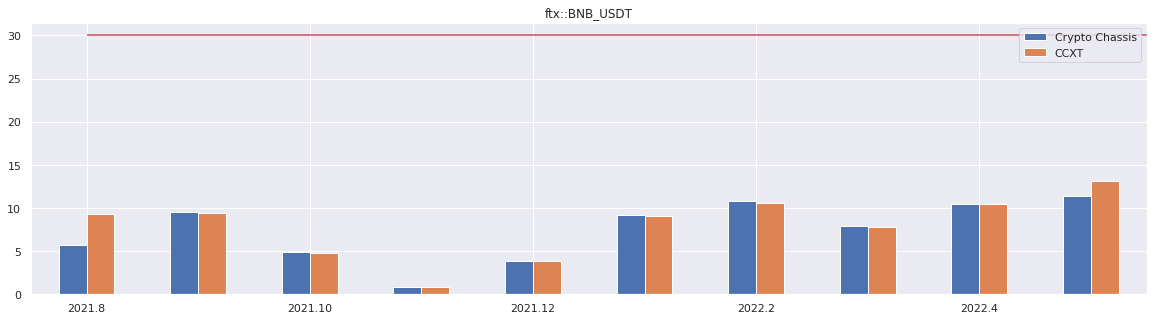

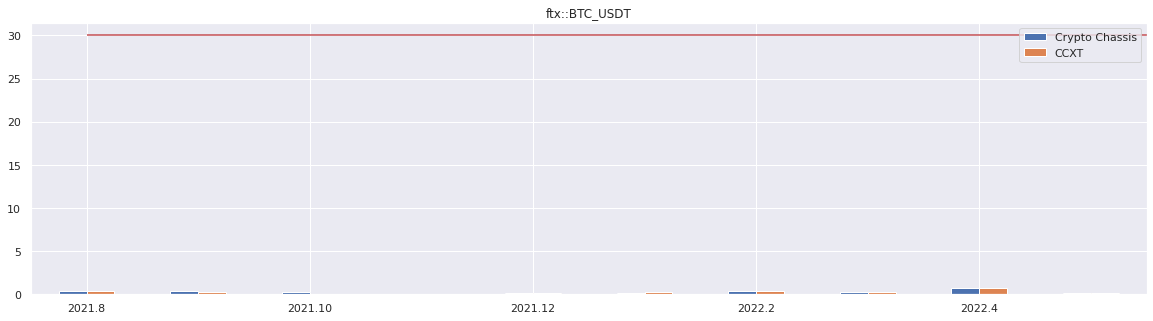

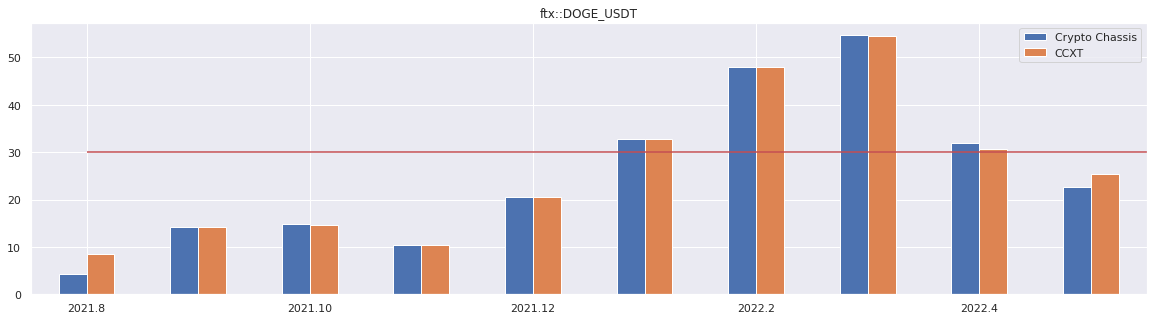

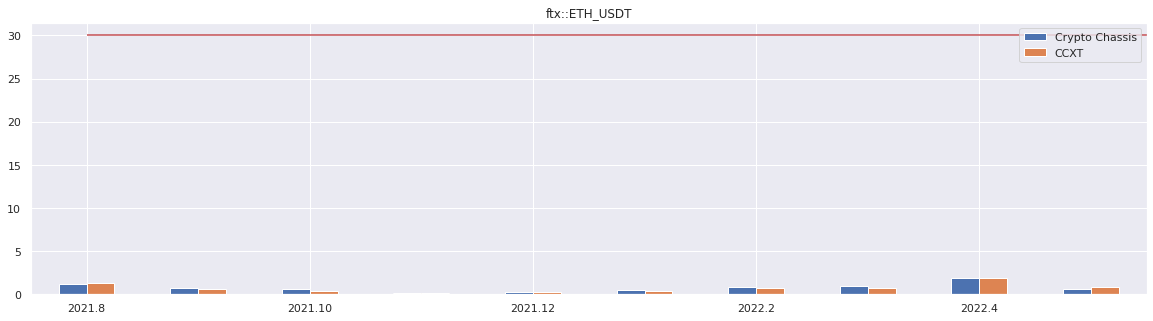

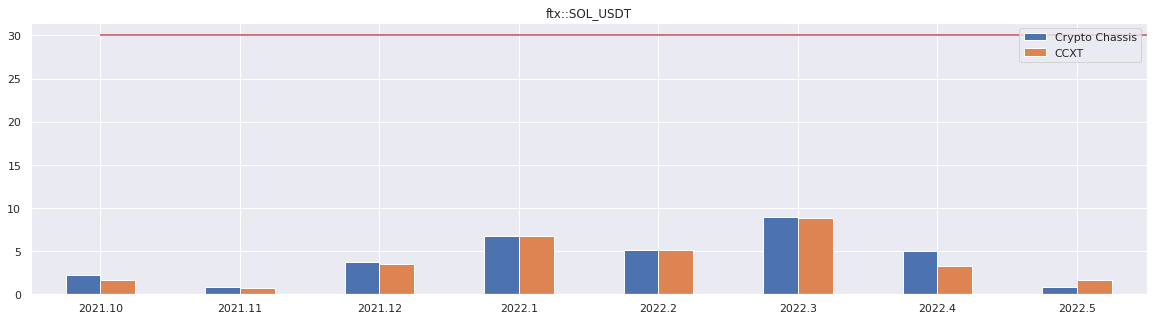

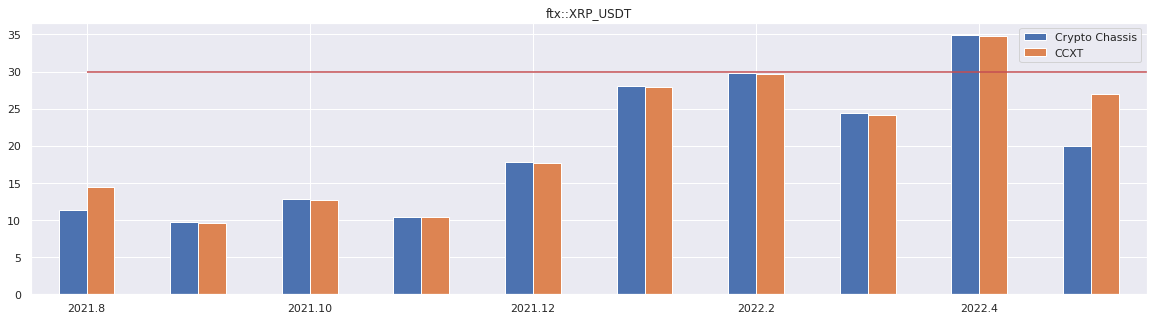

In [22]:
ramccqa.plot_bad_data_by_year_month_stats(
    ftx_bad_data_stats_by_year_month_qa, config["stats"]["threshold"]
)

# Compare Gateio QA stats

In [23]:
gateio_universe = [
    full_symbol
    for full_symbol in common_universe
    if full_symbol.startswith("gateio")
]
gateio_universe

['gateio::BTC_USDT',
 'gateio::BNB_USDT',
 'gateio::EOS_USDT',
 'gateio::SOL_USDT',
 'gateio::DOGE_USDT',
 'gateio::ETH_USDT',
 'gateio::XRP_USDT',
 'gateio::ADA_USDT']

In [24]:
ccxt_gateio_data = ccxt_client.read_data(
    gateio_universe, **config["data"]["read_data"]
)
ccxt_gateio_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-06-22 14:50:00+00:00,gateio::BTC_USDT,30140.88,167073.232956
2021-06-22 14:51:00+00:00,gateio::BTC_USDT,30186.85,221935.631630
2021-06-22 14:52:00+00:00,gateio::BTC_USDT,30258.63,187827.498050


In [25]:
crypto_chassis_gateio_data = crypto_chassis_client.read_data(
    gateio_universe, **config["data"]["read_data"]
)
crypto_chassis_gateio_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-10-12 04:07:00+00:00,gateio::ADA_USDT,2.105100,127.599000
2021-10-12 04:07:00+00:00,gateio::BNB_USDT,407.353800,0.616193
2021-10-12 04:07:00+00:00,gateio::DOGE_USDT,0.224157,9310.630000


In [26]:
crypto_chassis_timestamp_gateio_stats = ramccqa.get_timestamp_stats(
    crypto_chassis_gateio_data, crypto_chassis_vendor
)
ccxt_timestamp_gateio_stats = ramccqa.get_timestamp_stats(
    ccxt_gateio_data, ccxt_vendor
)
#
gateio_timestamp_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_timestamp_gateio_stats,
    ccxt_timestamp_gateio_stats,
)
gateio_timestamp_stats_qa

min_timestamp                                       max_timestamp                           days_available     
                             Crypto Chassis                      CCXT            Crypto Chassis                      CCXT Crypto Chassis CCXT
gateio::ADA_USDT  2021-10-12 04:07:00+00:00 2021-06-22 20:35:00+00:00 2022-05-18 10:08:00+00:00 2022-05-06 14:43:00+00:00            218  317
gateio::BNB_USDT  2021-10-12 04:07:00+00:00 2021-06-22 22:30:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 14:49:00+00:00            218  317
gateio::BTC_USDT  2021-10-12 04:08:00+00:00 2021-06-22 14:50:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 14:52:00+00:00            218  318
gateio::DOGE_USDT 2021-10-12 04:07:00+00:00 2021-06-22 19:38:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 14:55:00+00:00            218  317
gateio::EOS_USDT  2021-10-12 04:07:00+00:00 2021-06-22 23:28:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 14:58:00+00:00            218  317
gateio::ETH_USDT  2021-10-12 04:08:00+00:00 2021-06-22 15:48:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 15:00:00+00:00            218  317
gateio::SOL_USDT  2021-10-13 17:49:00+00:00 2021-06-22 16:45:00+00:00 2022-05-18 10:08:00+00:00 2022-05-06 15:09:00+00:00            216  317
gateio::XRP_USDT  2021-10-12 04:08:00+00:00 2021-06-22 17:43:00+00:00 2022-05-18 10:09:00+00:00 2022-05-06 15:12:00+00:00            218  317

In [27]:
crypto_chassis_bad_data_gateio_stats = ramccqa.get_bad_data_stats(
    crypto_chassis_gateio_data, agg_level_full_symbol, crypto_chassis_vendor
)
ccxt_bad_data_gateio_stats = ramccqa.get_bad_data_stats(
    ccxt_gateio_data, agg_level_full_symbol, ccxt_vendor
)
#
gateio_bad_data_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_gateio_stats,
    ccxt_bad_data_gateio_stats,
)
gateio_bad_data_stats_qa

bad data [%]            missing bars [%]              volume=0 [%]                 NaNs [%]     
                  Crypto Chassis       CCXT   Crypto Chassis       CCXT Crypto Chassis      CCXT Crypto Chassis CCXT
gateio::ADA_USDT        0.674872  17.043987         0.674872  16.608424            0.0  0.435563            0.0  0.0
gateio::BNB_USDT        0.359549  16.637957         0.359549  16.617628            0.0  0.020330            0.0  0.0
gateio::BTC_USDT        0.342368  16.631835         0.342368  16.626158            0.0  0.005678            0.0  0.0
gateio::DOGE_USDT       0.364003  16.807608         0.364003  16.616409            0.0  0.191199            0.0  0.0
gateio::EOS_USDT        6.371010  21.365249         6.371010  16.627278            0.0  4.737971            0.0  0.0
gateio::ETH_USDT        0.094819  16.623168         0.094819  16.623168            0.0  0.000000            0.0  0.0
gateio::SOL_USDT        1.706301  22.880795         1.706301  16.622509            0.0  6.258286            0.0  0.0
gateio::XRP_USDT        0.496688  16.746183         0.496688  16.627127            0.0  0.119055            0.0  0.0

In [28]:
crypto_chassis_bad_data_gateio_stats_by_year_month = ramccqa.get_bad_data_stats(
    crypto_chassis_gateio_data,
    agg_level_full_symbol_year_month,
    crypto_chassis_vendor,
)
ccxt_bad_data_gateio_stats_by_year_month = ramccqa.get_bad_data_stats(
    ccxt_gateio_data, agg_level_full_symbol_year_month, ccxt_vendor
)
#
gateio_bad_data_stats_by_year_month_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_gateio_stats_by_year_month,
    ccxt_bad_data_gateio_stats_by_year_month,
)
gateio_bad_data_stats_by_year_month_qa

bad data [%]             missing bars [%]               volume=0 [%]                  NaNs [%]     
                          Crypto Chassis        CCXT   Crypto Chassis        CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
gateio::ADA_USDT  2021 10       0.304697  100.000000         0.304697  100.000000            0.0   0.000000            0.0  0.0
                       11       0.789352   38.687500         0.789352   38.229167            0.0   0.458333            0.0  0.0
                       12       0.331541    0.322581         0.331541    0.000000            0.0   0.322581            0.0  0.0
                  2022 1        0.259857    0.250896         0.259857    0.000000            0.0   0.250896            0.0  0.0
                       2        0.870536    0.870536         0.870536    0.000000            0.0   0.870536            0.0  0.0
                       3        0.918459    0.658602         0.918459    0.000000            0.0   0.658602            0.0  0.0
                       4        0.974537    0.974537         0.974537    0.000000            0.0   0.974537            0.0  0.0
                       5        0.984495    1.410193         0.984495    0.000000            0.0   1.410193            0.0  0.0
gateio::BNB_USDT  2021 10       0.287185  100.000000         0.287185  100.000000            0.0   0.000000            0.0  0.0
                       11       0.076389   38.284722         0.076389   38.284722            0.0   0.000000            0.0  0.0
                       12       0.008961    0.000000         0.008961    0.000000            0.0   0.000000            0.0  0.0
                  2022 1        0.013441    0.004480         0.013441    0.000000            0.0   0.004480            0.0  0.0
                       2        0.047123    0.044643         0.047123    0.000000            0.0   0.044643            0.0  0.0
                       3        0.450269    0.053763         0.450269    0.000000            0.0   0.053763            0.0  0.0
                       4        1.763889    0.062500         1.763889    0.000000            0.0   0.062500            0.0  0.0
                       5        0.091670    0.123609         0.091670    0.000000            0.0   0.123609            0.0  0.0
gateio::BTC_USDT  2021 10       0.301205  100.000000         0.301205  100.000000            0.0   0.000000            0.0  0.0
                       11       0.078704   38.314815         0.078704   38.312500            0.0   0.002315            0.0  0.0
                       12       0.040323    0.004480         0.040323    0.000000            0.0   0.004480            0.0  0.0
                  2022 1        0.011201    0.002240         0.011201    0.000000            0.0   0.002240            0.0  0.0
                       2        0.024802    0.022321         0.024802    0.000000            0.0   0.022321            0.0  0.0
                       3        0.396505    0.000000         0.396505    0.000000            0.0   0.000000            0.0  0.0
                       4        1.724537    0.023148         1.724537    0.000000            0.0   0.023148            0.0  0.0
                       5        0.003986    0.012356         0.003986    0.000000            0.0   0.012356            0.0  0.0
gateio::DOGE_USDT 2021 10       0.297692  100.000000         0.297692  100.000000            0.0   0.000000            0.0  0.0
                       11       0.217593   38.462963         0.217593   38.340278            0.0   0.122685            0.0  0.0
                       12       0.248656    0.188172         0.248656    0.000000            0.0   0.188172            0.0  0.0
                  2022 1        0.047043    0.038082         0.047043    0.000000            0.0   0.038082            0.0  0.0
                       2        0.803571    0.803571         0.803571    0.000000            0.0   0.803571            0.0  0.0
                       3        0.710125    0.459229        

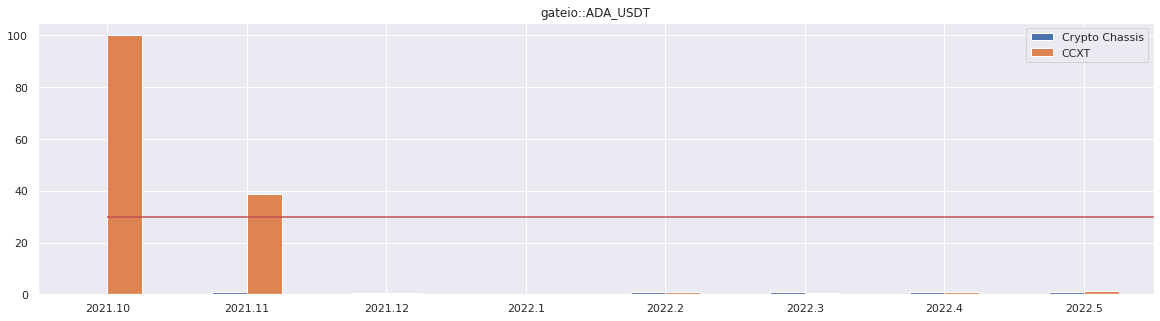

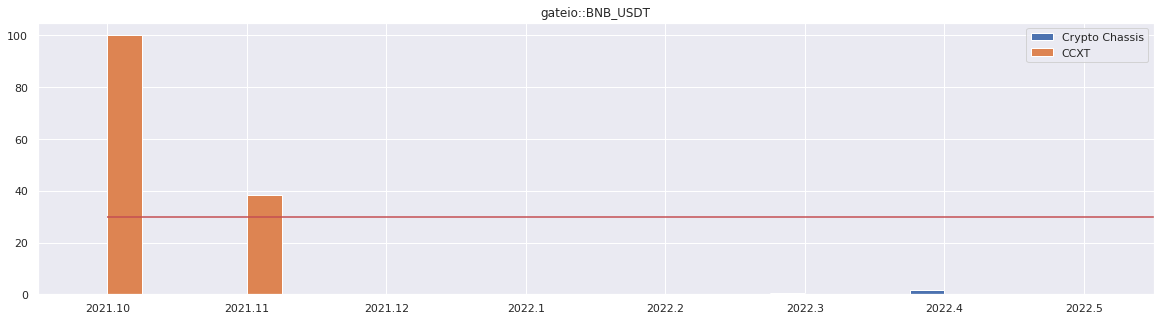

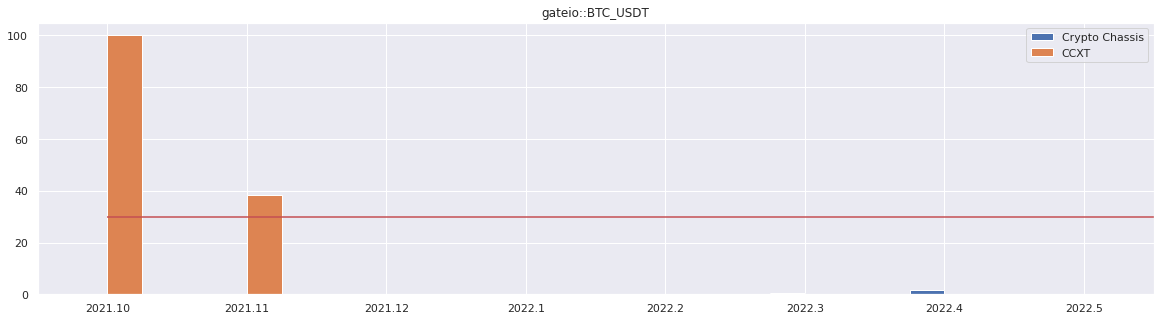

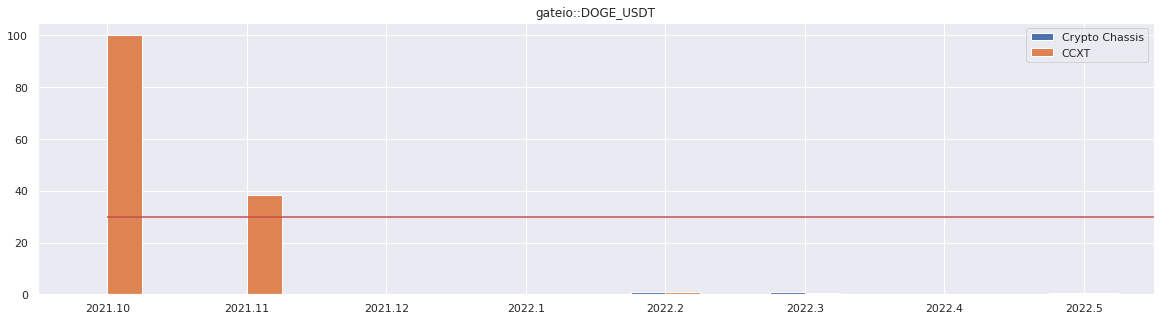

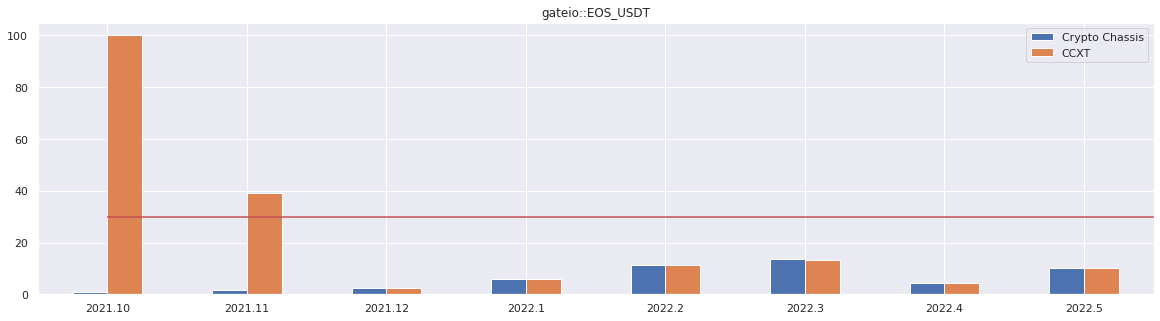

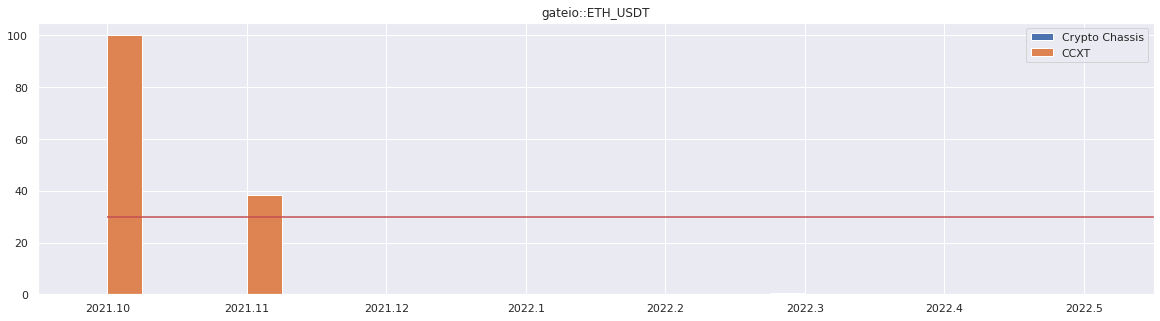

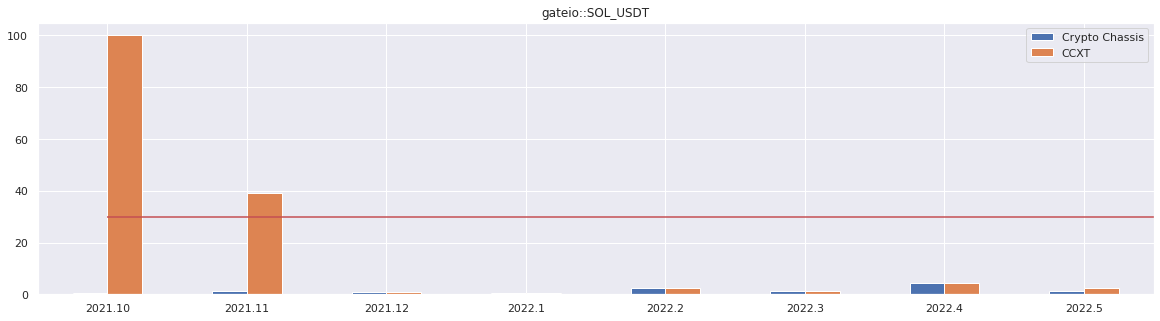

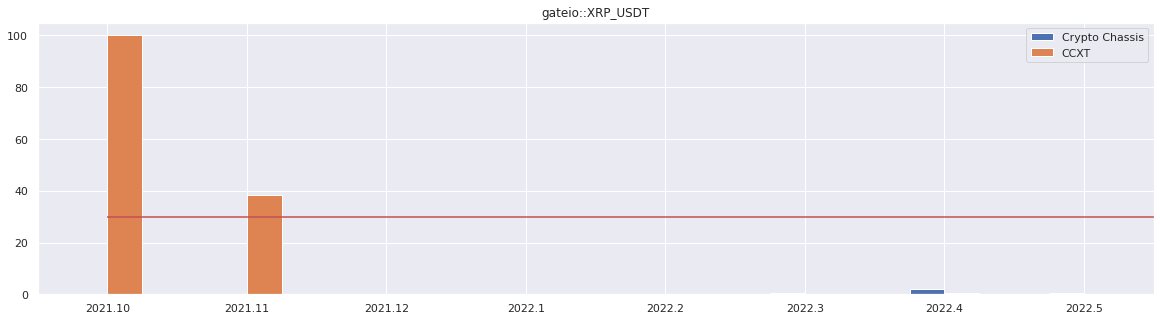

In [29]:
ramccqa.plot_bad_data_by_year_month_stats(
    gateio_bad_data_stats_by_year_month_qa, config["stats"]["threshold"]
)

# Compare Kucoin QA stats

In [30]:
kucoin_universe = [
    full_symbol
    for full_symbol in common_universe
    if full_symbol.startswith("kucoin")
]
kucoin_universe

['kucoin::ADA_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::XRP_USDT',
 'kucoin::BTC_USDT',
 'kucoin::EOS_USDT',
 'kucoin::SOL_USDT',
 'kucoin::BNB_USDT',
 'kucoin::ETH_USDT']

In [31]:
ccxt_kucoin_data = ccxt_client.read_data(
    kucoin_universe, **config["data"]["read_data"]
)
ccxt_kucoin_data.head(3)

,full_symbol,close,volume
timestamp,,,
2018-08-17 00:00:00+00:00,kucoin::BTC_USDT,6325.770051,0.025074
2018-08-17 00:01:00+00:00,kucoin::BTC_USDT,6309.204997,0.000871
2018-08-17 00:01:00+00:00,kucoin::ETH_USDT,286.712987,0.017500


In [32]:
crypto_chassis_kucoin_data = crypto_chassis_client.read_data(
    kucoin_universe, **config["data"]["read_data"]
)
crypto_chassis_kucoin_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-08-07 00:00:00+00:00,kucoin::ADA_USDT,1.402079,6508.498148
2021-08-07 00:00:00+00:00,kucoin::BNB_USDT,341.980000,27.015942
2021-08-07 00:00:00+00:00,kucoin::BTC_USDT,42804.900000,8.374341


In [33]:
crypto_chassis_timestamp_kucoin_stats = ramccqa.get_timestamp_stats(
    crypto_chassis_kucoin_data, crypto_chassis_vendor
)
ccxt_timestamp_kucoin_stats = ramccqa.get_timestamp_stats(
    ccxt_kucoin_data, ccxt_vendor
)
#
kucoin_timestamp_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_timestamp_kucoin_stats,
    ccxt_timestamp_kucoin_stats,
)
kucoin_timestamp_stats_qa

min_timestamp                                       max_timestamp                           days_available      
                             Crypto Chassis                      CCXT            Crypto Chassis                      CCXT Crypto Chassis  CCXT
kucoin::ADA_USDT  2021-08-07 00:00:00+00:00 2019-07-04 10:27:00+00:00 2022-05-18 09:58:00+00:00 2022-02-10 14:32:00+00:00            284   952
kucoin::BNB_USDT  2021-08-07 00:00:00+00:00 2019-06-19 10:00:00+00:00 2022-05-18 09:58:00+00:00 2022-02-10 14:56:00+00:00            284   967
kucoin::BTC_USDT  2021-08-07 00:00:00+00:00 2018-08-17 00:00:00+00:00 2022-05-18 09:59:00+00:00 2022-02-10 14:59:00+00:00            284  1273
kucoin::DOGE_USDT 2021-08-07 00:00:00+00:00 2021-02-09 03:00:00+00:00 2022-05-18 09:58:00+00:00 2022-02-10 15:02:00+00:00            284   366
kucoin::EOS_USDT  2021-08-07 00:00:00+00:00 2018-08-17 00:10:00+00:00 2022-05-18 09:59:00+00:00 2022-02-10 15:06:00+00:00            284  1273
kucoin::ETH_USDT  2021-08-07 00:00:00+00:00 2018-08-17 00:01:00+00:00 2022-05-18 09:59:00+00:00 2022-02-10 15:09:00+00:00            284  1273
kucoin::SOL_USDT  2021-10-13 17:49:00+00:00 2021-08-04 10:00:00+00:00 2022-05-18 09:59:00+00:00 2022-02-10 15:28:00+00:00            216   190
kucoin::XRP_USDT  2021-08-07 00:00:00+00:00 2018-12-03 16:58:00+00:00 2022-05-18 09:59:00+00:00 2022-02-10 15:31:00+00:00            284  1164

In [34]:
crypto_chassis_bad_data_kucoin_stats = ramccqa.get_bad_data_stats(
    crypto_chassis_kucoin_data, agg_level_full_symbol, crypto_chassis_vendor
)
ccxt_bad_data_kucoin_stats = ramccqa.get_bad_data_stats(
    ccxt_kucoin_data, agg_level_full_symbol, ccxt_vendor
)
#
kucoin_bad_data_stats_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_kucoin_stats,
    ccxt_bad_data_kucoin_stats,
)
kucoin_bad_data_stats_qa

bad data [%]            missing bars [%]              volume=0 [%]                  NaNs [%]     
                  Crypto Chassis       CCXT   Crypto Chassis       CCXT Crypto Chassis       CCXT Crypto Chassis CCXT
kucoin::ADA_USDT        0.199483  46.558741         0.199483  14.319763            0.0  32.238977            0.0  0.0
kucoin::BNB_USDT        0.294219  60.489152         0.294219  14.734591            0.0  45.754561            0.0  0.0
kucoin::BTC_USDT        1.089950  17.961145         1.089950  16.424576            0.0   1.536570            0.0  0.0
kucoin::DOGE_USDT       1.065781  41.462171         1.065781  38.927701            0.0   2.534471            0.0  0.0
kucoin::EOS_USDT        2.073689  36.604023         2.073689  23.847980            0.0  12.756043            0.0  0.0
kucoin::ETH_USDT        0.105235  20.213148         0.105235  17.672403            0.0   2.540745            0.0  0.0
kucoin::SOL_USDT        0.342937  77.271483         0.342937  75.172764            0.0   2.098719            0.0  0.0
kucoin::XRP_USDT        0.096933  31.608797         0.096933  18.636685            0.0  12.972112            0.0  0.0

In [35]:
crypto_chassis_bad_data_kucoin_stats_by_year_month = ramccqa.get_bad_data_stats(
    crypto_chassis_kucoin_data,
    agg_level_full_symbol_year_month,
    crypto_chassis_vendor,
)
ccxt_bad_data_kucoin_stats_by_year_month = ramccqa.get_bad_data_stats(
    ccxt_kucoin_data, agg_level_full_symbol_year_month, ccxt_vendor
)
#
kucoin_bad_data_stats_by_year_month_qa = ramccqa.compare_data_stats(
    crypto_chassis_bad_data_kucoin_stats_by_year_month,
    ccxt_bad_data_kucoin_stats_by_year_month,
)
kucoin_bad_data_stats_by_year_month_qa

bad data [%]            missing bars [%]              volume=0 [%]                 NaNs [%]     
                          Crypto Chassis       CCXT   Crypto Chassis       CCXT Crypto Chassis      CCXT Crypto Chassis CCXT
kucoin::ADA_USDT  2021 8        0.061111   0.302419         0.061111   0.000000            0.0  0.302419            0.0  0.0
                       9        0.259259  47.196759         0.259259  47.196759            0.0  0.000000            0.0  0.0
                       10       0.217294  93.279570         0.217294  93.279570            0.0  0.000000            0.0  0.0
                       11       0.004630  93.055556         0.004630  93.055556            0.0  0.000000            0.0  0.0
                       12       0.212814  89.921595         0.212814  89.919355            0.0  0.002240            0.0  0.0
                  2022 1        0.143369  93.279570         0.143369  93.279570            0.0  0.000000            0.0  0.0
                       2        0.148810  89.170823         0.148810  89.156365            0.0  0.014458            0.0  0.0
kucoin::BNB_USDT  2021 8        0.025000   0.035842         0.025000   0.000000            0.0  0.035842            0.0  0.0
                       9        0.277778  50.337963         0.277778  50.331019            0.0  0.006944            0.0  0.0
                       10       0.300179  96.639785         0.300179  96.639785            0.0  0.000000            0.0  0.0
                       11       0.002315  96.527778         0.002315  96.527778            0.0  0.000000            0.0  0.0
                       12       0.201613  96.639785         0.201613  96.639785            0.0  0.000000            0.0  0.0
                  2022 1        0.103047  96.639785         0.103047  96.639785            0.0  0.000000            0.0  0.0
                       2        0.116567  89.175146         0.116567  89.175146            0.0  0.000000            0.0  0.0
kucoin::BTC_USDT  2021 8        1.669444   0.000000         1.669444   0.000000            0.0  0.000000            0.0  0.0
                       9        6.627315  53.828704         6.627315  53.828704            0.0  0.000000            0.0  0.0
                       10       0.212814  96.639785         0.212814  96.639785            0.0  0.000000            0.0  0.0
                       11       0.002315  96.527778         0.002315  96.527778            0.0  0.000000            0.0  0.0
                       12       0.199373  96.639785         0.199373  96.639785            0.0  0.000000            0.0  0.0
                  2022 1        0.091846  96.639785         0.091846  96.639785            0.0  0.000000            0.0  0.0
                       2        0.096726  89.177489         0.096726  89.177489            0.0  0.000000            0.0  0.0
kucoin::DOGE_USDT 2021 8        1.680556   0.400986         1.680556   0.000000            0.0  0.400986            0.0  0.0
                       9        6.733796  50.875000         6.733796  50.840278            0.0  0.034722            0.0  0.0
                       10       0.275538  96.639785         0.275538  96.639785            0.0  0.000000            0.0  0.0
                       11       0.004630  96.527778         0.004630  96.527778            0.0  0.000000            0.0  0.0
                       12       0.300179  96.642025         0.300179  96.639785            0.0  0.002240            0.0  0.0
                  2022 1        0.748208  96.644265         0.748208  96.639785            0.0  0.004480            0.0  0.0
                       2        0.590278  89.194258         0.590278  89.179831            0.0  0.014427            0.0  0.0
kucoin::EOS_USDT  2021 8        1.316667   1.868280         1.316667   0.000000            0.0  1.868280            0.0  0.0
                       9        0.717593  50.358796         0.717593  49.997685            0.0  0.361111            0.0  0.0
                       10   

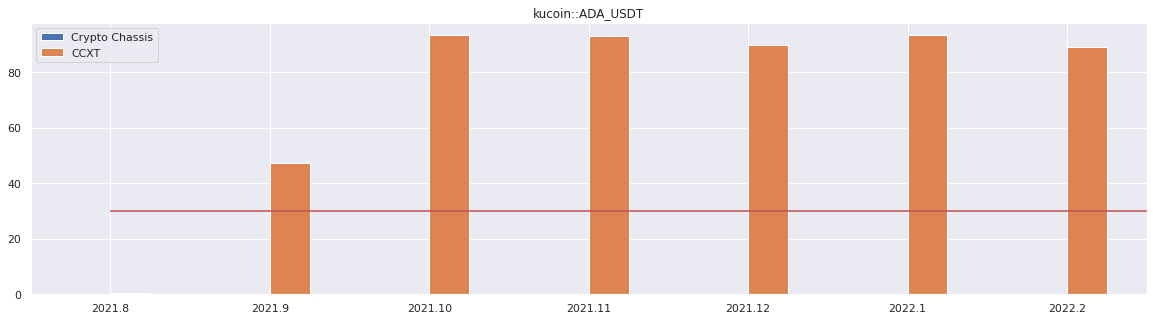

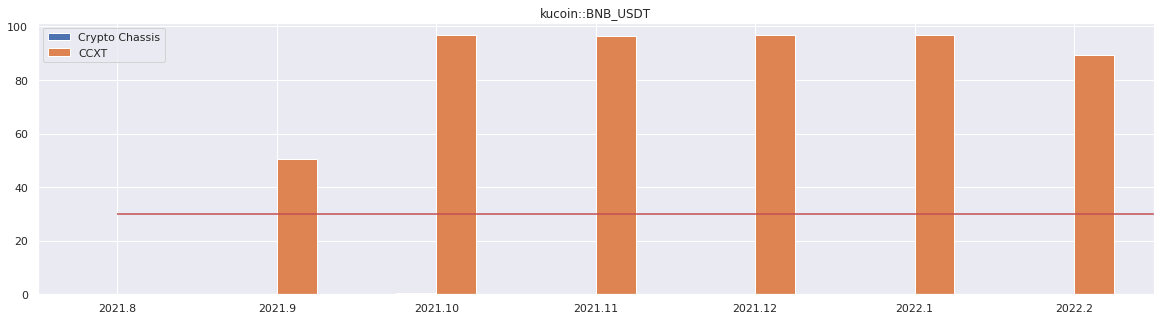

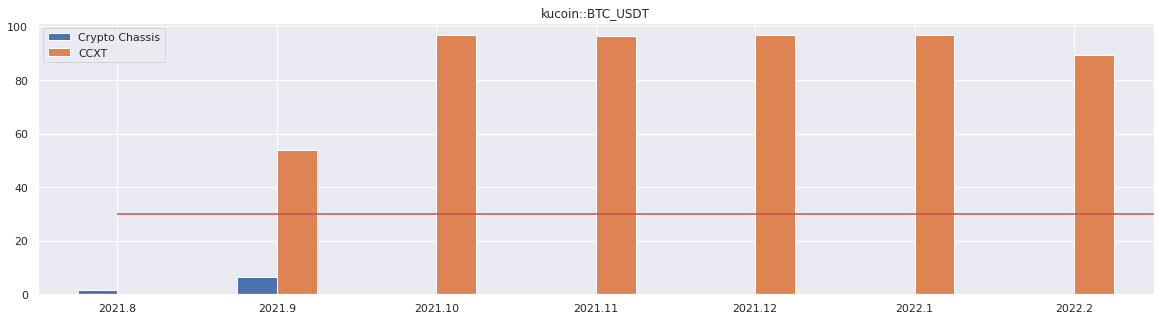

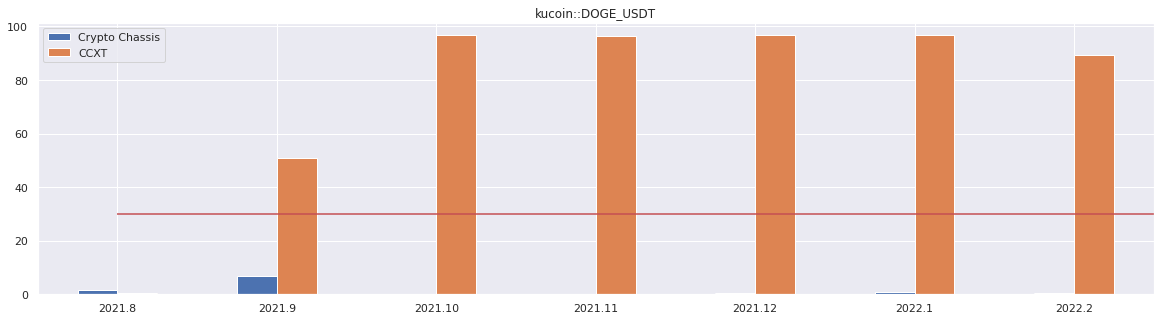

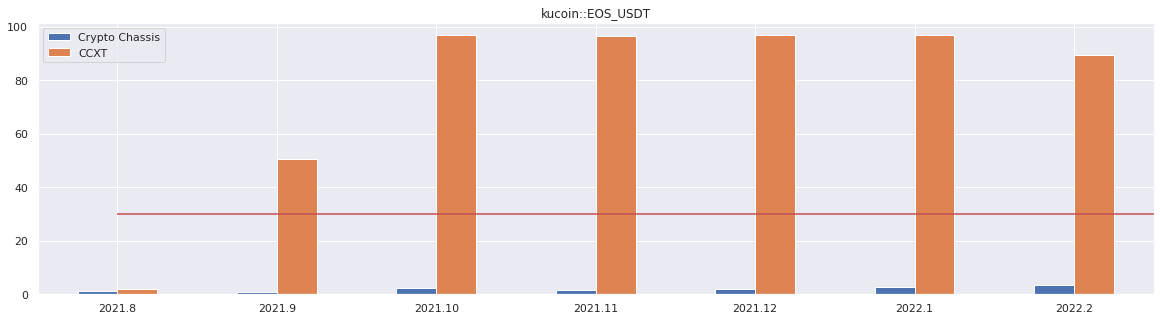

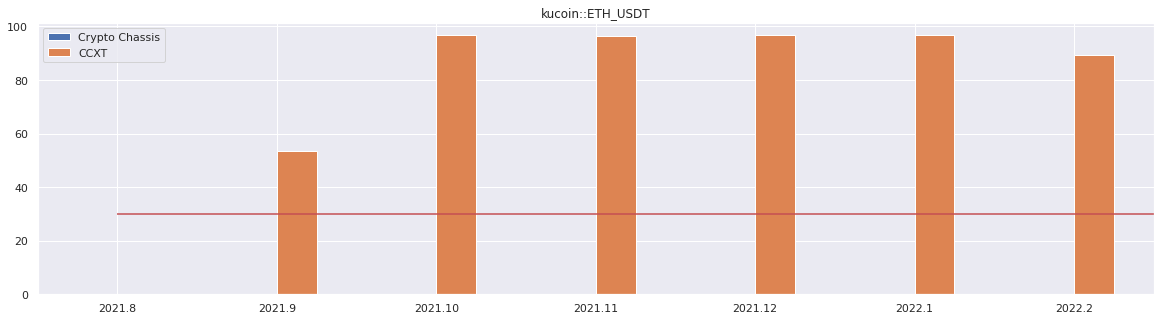

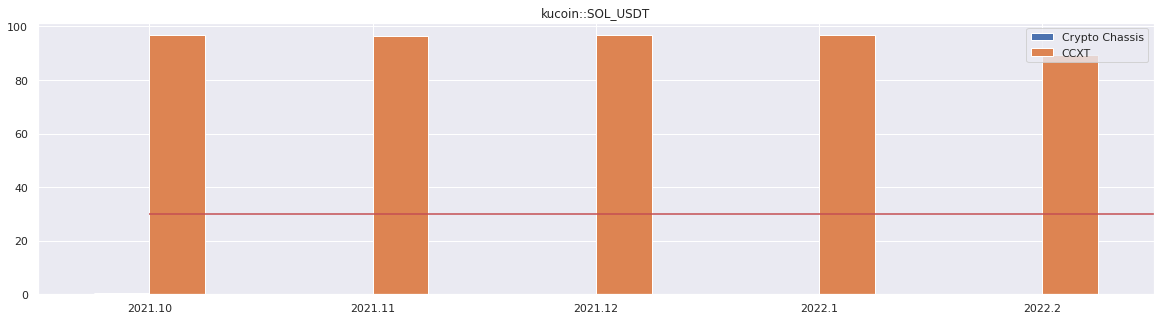

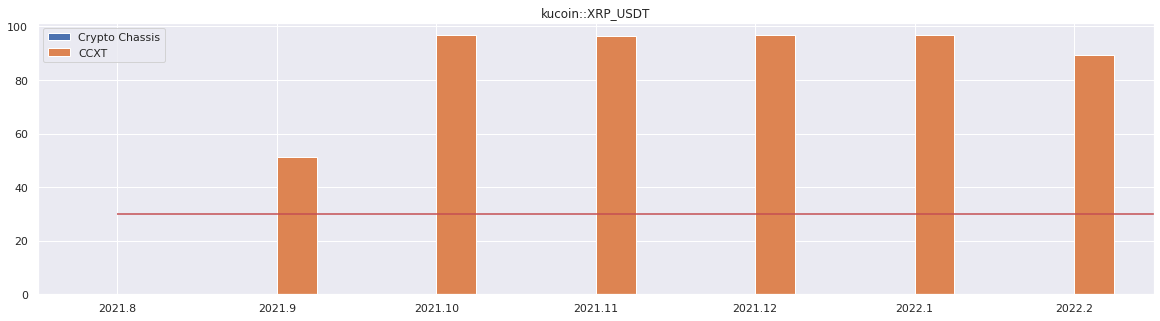

In [36]:
ramccqa.plot_bad_data_by_year_month_stats(
    kucoin_bad_data_stats_by_year_month_qa, config["stats"]["threshold"]
)